In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import keras
import tensorflow as tf
import random

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import random
#import tqdm
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
#Importing drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Setting file paths in drive
path = '/content/drive/MyDrive/CourseWork/Deeplearning for Vision and NLP/litter_detection_model'

#raw images
raw_image_path = path + '/raw_images'
punalur_raw_image_path = raw_image_path + '/Falkirk_Punalur/'
falkirk_raw_image_path = raw_image_path + '/Falkirk'

#annotated images
annotated_image_path = path + '/annotated_images'
punalur_annotated_image_path = annotated_image_path + '/Falkirk_Punalur'
falkirk_annotated_image_path = annotated_image_path + '/Falkirk'


(1600, 720, 3)


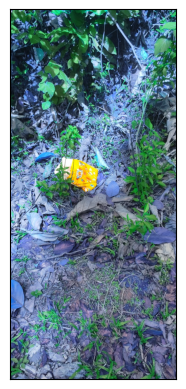

In [5]:
punalur_raw_images = [image for image in os.listdir(raw_image_path+'/Falkirk_Punalur/')]

first_image = cv2.imread(punalur_raw_image_path+punalur_raw_images[-1], cv2.COLOR_BGR2RGB)
print(first_image.shape)

plt.imshow(first_image)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()


(256, 256, 3)

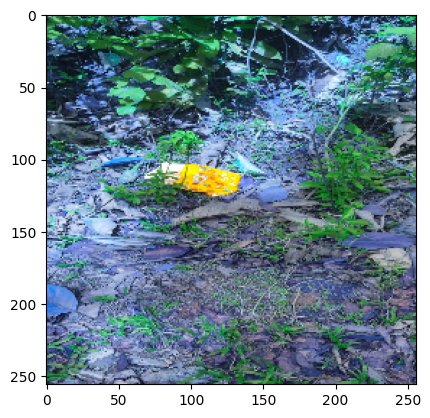

In [6]:
resized_image = cv2.resize(first_image, (256, 256))
plt.imshow(resized_image)
resized_image.shape

(256, 256, 3)

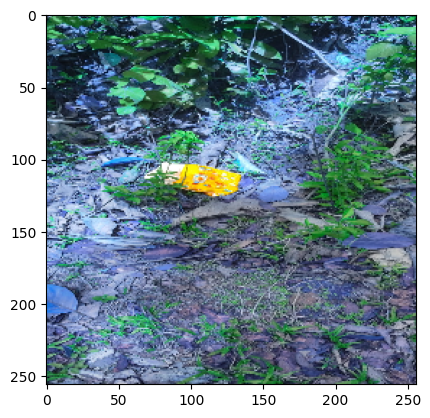

In [7]:
normalized_image = resized_image.astype(np.float32) / 255.0

plt.imshow(normalized_image)
normalized_image.shape

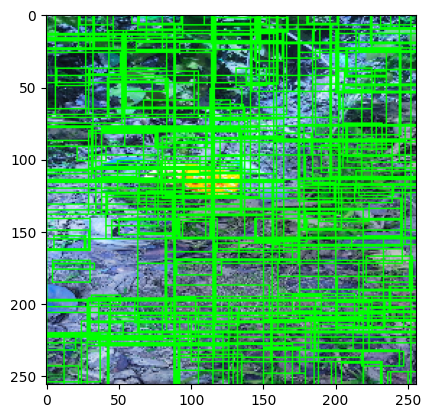

In [8]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

ss.setBaseImage(normalized_image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = normalized_image.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imOut)

In [9]:
txt_files = [f for f in os.listdir(punalur_annotated_image_path) if f.lower().endswith('.txt')]
try:
  txt_files.remove('classes.txt')
except ValueError:
  print(f'classes.txt not present')

# Reading the content of each .txt file

annotated_punalur_files = []
for txt_file in txt_files:
    # print(txt_file)
    file_path = os.path.join(punalur_annotated_image_path, txt_file)
    with open(file_path, 'r') as f:
        cols = ['label_class', 'x_center', 'y_center', 'width', 'height']
        content = pd.read_csv(f, sep=' ', names = cols)
    annotated_punalur_files.append({txt_file:content})

classes.txt not present


In [10]:
def get_rectangle_object_from_image(image, x, y, w, h):
  # Cropping the object and resizing to the standard size
  cropped_image = image[y : y+h, x : x+w]
  resized_image = cv2.resize(cropped_image, (224, 224), interpolation = cv2.INTER_AREA)
  # resized_image = cv2.resize(cropped_image, (224, 224), interpolation = cv2.INTER_CUBIC)
  # resized_image = cv2.resize(cropped_image, (224, 224))
  return resized_image


In [11]:
def get_rectangle_coordinates_from_image(image, x_center, y_center, height, width):
  H, W, _ = image.shape
  x1 = int((x_center - width / 2) * W)
  y1 = int((y_center - height / 2) * H)
  x2 = int((x_center + width / 2) * W)
  y2 = int((y_center + height / 2) * H)
  return x1, y1, x2, y2

In [12]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [13]:
def perform_image_preprocessing(img):
  resized_image = cv2.resize(img, (256, 256))
  normalized_image = resized_image.astype(np.float32) / 255.0
  return normalized_image

In [14]:
max_proposal = 2000
max_samples = 30
# IOU_treshold_plane = 0.7
IOU_treshold_plane = 0.7
IOU_treshold_background = 0.3

In [15]:

def get_train_images_labels(annotated_files_list):

  train_images = []
  train_labels = []

  for annotated_file in tqdm(annotated_files_list, desc="Processing images"):

    #Extracting file name to fetch the corresponding raw image
    file_name = list(annotated_file.keys())[0]

    # Reading the corresponding raw image
    image_path = os.path.join(punalur_raw_image_path, file_name.replace(".txt", ".jpg"))
    base_image = cv2.imread(image_path)
    if base_image is None:
      continue
    base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

    base_image = perform_image_preprocessing(base_image)
    base_image_copy = base_image.copy()

    annotated_coordinate_list = []

    for entry in annotated_file:

      #Iterating through each lines of the annotated file(ie, different object labels)
      df = annotated_file[entry]
      for index, row in df.iterrows():
        class_label = row['label_class']
        x_center = row['x_center']
        y_center = row['y_center']
        height = row['height']
        width = row['width']
      
      x1, y1, x2, y2 = get_rectangle_coordinates_from_image(base_image_copy, x_center, y_center, height, width)
      annotated_coordinate_dict = {'x1':x1, 'y1': y1, 'x2': x2, 'y2': y2}
      annotated_coordinate_list.append(annotated_coordinate_dict)
      # cv2.rectangle(base_image,(x1,y1),(x2,y2),(255,0,0), 5)
    # plt.imshow(base_image)
    # break

    cv2.setUseOptimized(True);
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(base_image_copy)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    
    counter = 0
    flag = 0
    fflag = 0
    bflag = 0
    falsecounter = 0

    for index, result in enumerate(ssresults):
      if index < max_proposal and flag == 0:
        for box_values in annotated_coordinate_list:
          x, y, w, h = result
          iou = get_iou(box_values,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
          if counter < max_samples:
            if iou > IOU_treshold_plane:
              train_images.append(get_rectangle_object_from_image(base_image_copy, x, y, w, h))
              train_labels.append(1)
              counter += 1
            else:
              fflag = 1
            if falsecounter < max_samples:
              if iou < IOU_treshold_background:
                train_images.append(get_rectangle_object_from_image(base_image_copy, x, y, w, h))
                train_labels.append(0)
                falsecounter += 1
            else:
              bflag = 1
        if fflag == 1 and bflag == 1:
            flag = 1

  return train_images, train_labels


In [16]:
X_new, Y_new = get_train_images_labels(annotated_punalur_files)
X_new = np.array(X_new)
Y_new = np.array(Y_new)
# X_new = preprocess_input(X_new)

Processing images:   0%|          | 0/230 [00:00<?, ?it/s]

**Test1**

In [17]:
# num_classes = 1  #Class: Trash

# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# x = base_model.output
# x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# # predictions = Dense(num_classes, activation='softmax')(x)
# predictions = Dense(num_classes, activation='sigmoid')(x)

# model = Model(inputs = base_model.input, outputs=predictions)

In [18]:
# plt.imshow(X_new[-1])

In [19]:
# Y_new[-1]

In [20]:
# X_new = preprocess_input(X_new)
# Y_new = LabelBinarizer().fit_transform(Y_new)
# X_train, X_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.5, stratify=Y_new)

In [21]:
# X_new = preprocess_input(X_new)
# X_train, X_test , y_train, y_test = train_test_split(X_new,Y_new,test_size=0.50)

In [22]:
# X_test.shape

In [23]:
# # model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# epochs = 10 
# batch_size = 10

# history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_test, y_test))

In [24]:
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


**Testing**

In [25]:
vggmodel = VGG16(weights='imagenet', include_top=True)

for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
    
X= vggmodel.layers[-2].output
predictions = Dense(1, activation="sigmoid")(X)
model_final = Model(vggmodel.input,predictions)
opt = Adam(lr=0.0001)
model_final.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model_final.summary()

553467096/553467096 [==============================] - 3s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [26]:
# X_new = np.array(train_images)
# y_new = np.array(train_labels)

X_train, X_test , y_train, y_test = train_test_split(X_new,Y_new,test_size=0.10)

In [27]:
trdata    = ImageDataGenerator(horizontal_flip=False, vertical_flip=False, rotation_range=0)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata    = ImageDataGenerator(horizontal_flip=False, vertical_flip=False, rotation_range=0)
testdata  = tsdata.flow(x=X_test, y=y_test)

In [28]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5",
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto', period=1)

early = EarlyStopping(monitor='val_loss', 
                      min_delta=0,
                      patience=100,
                      verbose=1,
                      mode='auto')

hist = model_final.fit_generator(generator = traindata,
                                 steps_per_epoch= 10,
                                 epochs= 20, 
                                 validation_data = testdata,
                                 validation_steps = 2,
                                 callbacks = [checkpoint,early])

Epoch 1/20


<ipython-input-28-e7a0e23ab6a4>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator = traindata,


10/10 [==============================] - ETA: 0s - loss: 722.6761 - accuracy: 0.8594
Epoch 1: val_loss improved from inf to 0.00000, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 25s 976ms/step - loss: 722.6761 - accuracy: 0.8594 - val_loss: 4.9745e-10 - val_accuracy: 1.0000
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.8554 - accuracy: 0.8938
Epoch 2: val_loss did not improve from 0.00000
10/10 [==============================] - 2s 189ms/step - loss: 0.8554 - accuracy: 0.8938 - val_loss: 0.4657 - val_accuracy: 1.0000
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.3134 - accuracy: 0.9875
Epoch 3: val_loss did not improve from 0.00000
10/10 [==============================] - 2s 189ms/step - loss: 0.3134 - accuracy: 0.9875 - val_loss: 1.0099e-04 - val_accuracy: 1.0000
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.9937
Epoch 4: val_loss improved from 0.00000 to 0.00000,

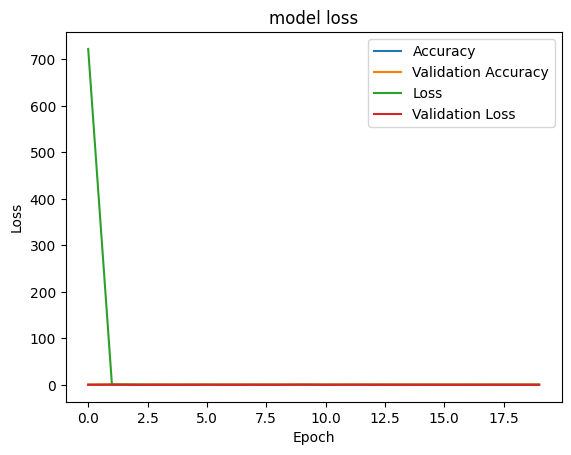

In [29]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss","Validation Loss"])
plt.show()

1/1 [==============================] - 1s 649ms/step
False
0.036017966
<class 'numpy.float32'>


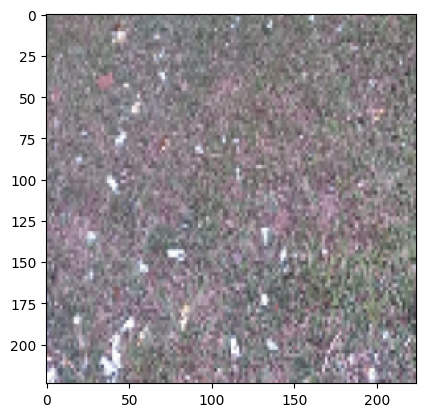

In [30]:
im = X_test[-2]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out = model_final.predict(img)
print(int(out[0][0]) > 0.7)
print(out[0][0])
print(type(out[0][0]))
# if out[0][0] > out[0][1]:
#     print("litter")
# else:
#     print("not litter")

/content/drive/MyDrive/CourseWork/Deeplearning for Vision and NLP/litter_detection_model/raw_images/test/Test1
1/1 [==============================] - 0s 19ms/step


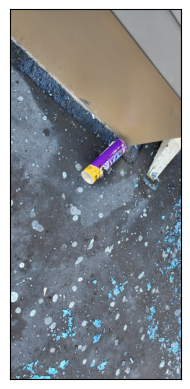

In [31]:
# img=random.choice(images)
# img = X_test[-2]
img = cv2.imread(raw_image_path + '/test/Test1.jpg')
print(raw_image_path + '/test/Test1')
# img = cv2.imread(punalur_raw_image_path+punalur_raw_images[-1])
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_final.predict(img)
        # print(f'out is {out}')
        if out[0][0] > 0.7:
            print(f'out is {out}')
            cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imout)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()